## Example with a SISO (Single Input Single Output) Pulley system

In this example we consider the three-pulley 
system analyzed in the original VRFT paper:

"Virtual reference feedback tuning: a direct method for the design offeedback controllers"
-- Campi et al. 2003

Import the libraries

In [1]:
import numpy as np
import scipy.signal as scipysig
import cvxpy as cp
import matplotlib.pyplot as plt

from typing import List
from cvxpy.expressions.expression import Expression
from cvxpy.constraints.constraint import Constraint
from pydeepc import DeePC
from pydeepc.utils import Data
from utils import System

### To ignore warnings about cp.ECOS not being available
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Define the loss callack for DeePC and the constraints

In [2]:

# Define the loss function for DeePC
def loss_callback(u: cp.Variable, y: cp.Variable) -> Expression:
    horizon, M, P = u.shape[0], u.shape[1], y.shape[1]
    # Sum_t ||y_t - 1||^2
    return 1e3 * cp.norm(y-1,'fro')**2 + 1e-1 * cp.norm(u, 'fro')**2

# Define the constraints for DeePC
def constraints_callback(u: cp.Variable, y: cp.Variable) -> List[Constraint]:
    horizon, M, P = u.shape[0], u.shape[1], y.shape[1]
    # Define a list of input/output constraints (no constraints here)
    return []

Define parameters and simulate DeePC

Simulating with 50 initial samples...
Simulating with 500 initial samples...


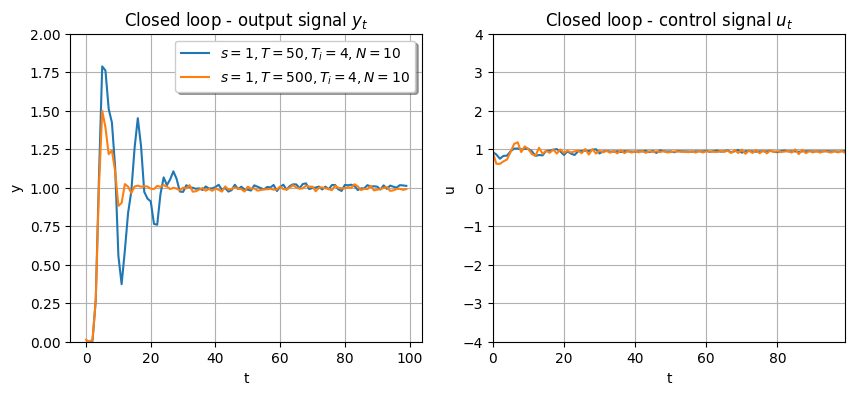

In [3]:

# DeePC paramters
s = 1                       # How many steps before we solve again the DeePC problem
T_INI = 4                   # Size of the initial set of data
T_list = [50, 500]          # Number of data points used to estimate the system
HORIZON = 10                # Horizon length
LAMBDA_G_REGULARIZER = 1    # g regularizer (see DeePC paper, eq. 8)
LAMBDA_Y_REGULARIZER = 1    # y regularizer (see DeePC paper, eq. 8)
LAMBDA_U_REGULARIZER = 0    # u regularizer
EXPERIMENT_HORIZON = 100    # Total number of steps

# Plant
# In this example we consider the three-pulley 
# system analyzed in the original VRFT paper:
# 
# "Virtual reference feedback tuning: 
#      a direct method for the design offeedback controllers"
# -- Campi et al. 2003

dt = 0.05
num = [0.28261, 0.50666]
den = [1, -1.41833, 1.58939, -1.31608, 0.88642]
sys = System(scipysig.TransferFunction(num, den, dt=dt).to_ss(), noise_std=1e-2)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plt.margins(x=0, y=0)


# Simulate for different values of T
for T in T_list:
    print(f'Simulating with {T} initial samples...')
    sys.reset()
    # Generate initial data and initialize DeePC
    data = sys.apply_input(u = np.random.normal(size=T).reshape((T, 1)))
    deepc = DeePC(data, Tini = T_INI, horizon = HORIZON)

    # Create initial data
    data_ini = Data(u = np.zeros((T_INI, 1)), y = np.zeros((T_INI, 1)))
    sys.reset(data_ini = data_ini)

    deepc.build_problem(
        build_loss = loss_callback,
        build_constraints = constraints_callback,
        lambda_g = LAMBDA_G_REGULARIZER,
        lambda_y = LAMBDA_Y_REGULARIZER,
        lambda_u = LAMBDA_U_REGULARIZER)

    for idx in range(EXPERIMENT_HORIZON // s):
        # Solve DeePC
        u_optimal, info = deepc.solve(data_ini = data_ini, warm_start=True, solver=cp.ECOS)


        # Apply optimal control input
        _ = sys.apply_input(u = u_optimal[:s, :])

        # Fetch last T_INI samples
        data_ini = sys.get_last_n_samples(T_INI)

    # Plot curve
    data = sys.get_all_samples()
    ax[0].plot(data.y[T_INI:], label=f'$s={s}, T={T}, T_i={T_INI}, N={HORIZON}$')
    ax[1].plot(data.u[T_INI:], label=f'$s={s}, T={T}, T_i={T_INI}, N={HORIZON}$')

ax[0].set_ylim(0, 2)
ax[1].set_ylim(-4, 4)
ax[0].set_xlabel('t')
ax[0].set_ylabel('y')
ax[0].grid()
ax[1].set_ylabel('u')
ax[1].set_xlabel('t')
ax[1].grid()
ax[0].set_title('Closed loop - output signal $y_t$')
ax[1].set_title('Closed loop - control signal $u_t$')
ax[0].legend(fancybox=True, shadow=True)
plt.show()

Example where the Hankel matrix is approximated using the explained variance

Simulating with 1000 initial samples...


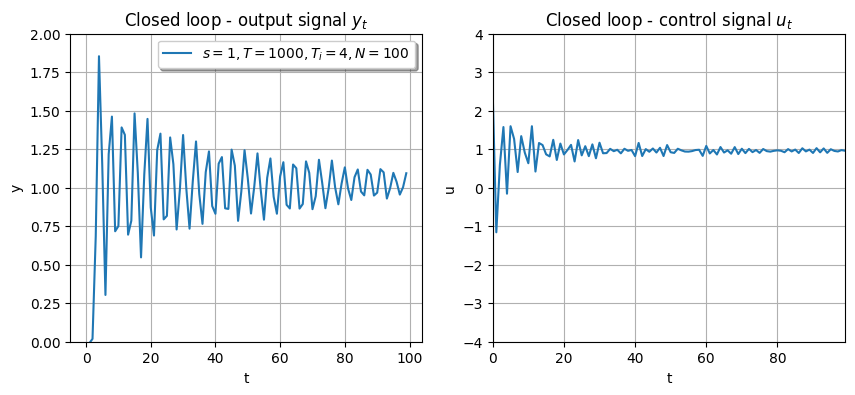

In [5]:

# DeePC paramters
s = 1                       # How many steps before we solve again the DeePC problem
T_INI = 4                   # Size of the initial set of data
T_list = [1000]              # Number of data points used to estimate the system
HORIZON = 100               # Horizon length
LAMBDA_G_REGULARIZER = 20   # g regularizer (see DeePC paper, eq. 8)
LAMBDA_Y_REGULARIZER = 0    # y regularizer (see DeePC paper, eq. 8)
LAMBDA_U_REGULARIZER = 0    # u regularizer
EXPERIMENT_HORIZON = 100    # Total number of steps

# Plant
# In this example we consider the three-pulley 
# system analyzed in the original VRFT paper:
# 
# "Virtual reference feedback tuning: 
#      a direct method for the design offeedback controllers"
# -- Campi et al. 2003

dt = 0.05
num = [0.28261, 0.50666]
den = [1, -1.41833, 1.58939, -1.31608, 0.88642]
sys = System(scipysig.TransferFunction(num, den, dt=dt).to_ss(), noise_std=1e-2)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
plt.margins(x=0, y=0)


# Simulate for different values of T
for T in T_list:
    print(f'Simulating with {T} initial samples...')
    sys.reset()
    # Generate initial data and initialize DeePC
    data = sys.apply_input(u = np.random.normal(size=T).reshape((T, 1)))
    deepc = DeePC(data, Tini = T_INI, horizon = HORIZON, explained_variance = .99)

    # Create initial data
    data_ini = Data(u = np.zeros((T_INI, 1)), y = np.zeros((T_INI, 1)))
    sys.reset(data_ini = data_ini)

    deepc.build_problem(
        build_loss = loss_callback,
        build_constraints = constraints_callback,
        lambda_g = LAMBDA_G_REGULARIZER,
        lambda_y = LAMBDA_Y_REGULARIZER,
        lambda_u = LAMBDA_U_REGULARIZER)

    for idx in range(EXPERIMENT_HORIZON // s):
        # Solve DeePC
        u_optimal, info = deepc.solve(data_ini = data_ini, warm_start=True, solver=cp.ECOS)


        # Apply optimal control input
        _ = sys.apply_input(u = u_optimal[:s, :])

        # Fetch last T_INI samples
        data_ini = sys.get_last_n_samples(T_INI)

    # Plot curve
    data = sys.get_all_samples()
    ax[0].plot(data.y[T_INI:], label=f'$s={s}, T={T}, T_i={T_INI}, N={HORIZON}$')
    ax[1].plot(data.u[T_INI:], label=f'$s={s}, T={T}, T_i={T_INI}, N={HORIZON}$')

ax[0].set_ylim(0, 2)
ax[1].set_ylim(-4, 4)
ax[0].set_xlabel('t')
ax[0].set_ylabel('y')
ax[0].grid()
ax[1].set_ylabel('u')
ax[1].set_xlabel('t')
ax[1].grid()
ax[0].set_title('Closed loop - output signal $y_t$')
ax[1].set_title('Closed loop - control signal $u_t$')
ax[0].legend(fancybox=True, shadow=True)
plt.show()